In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# missing values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
# one-hot coding the Origin column
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

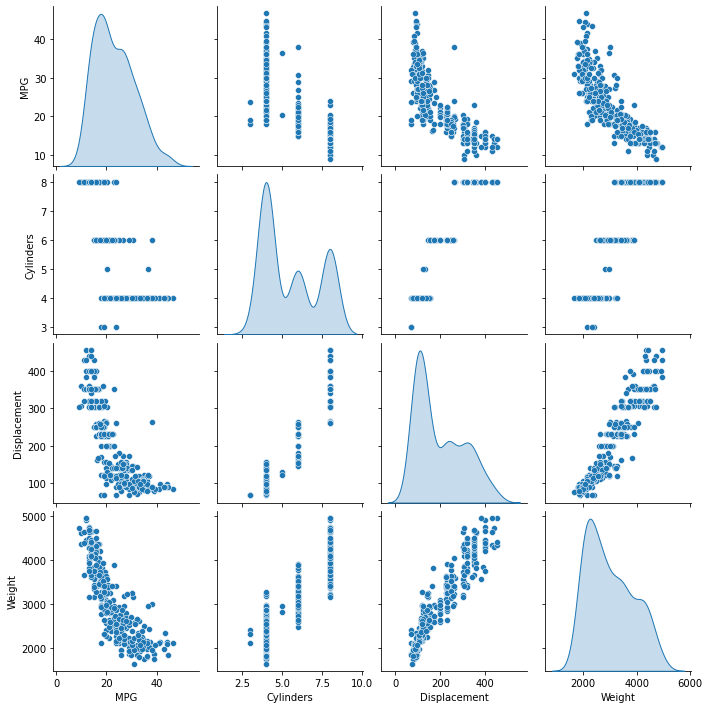

In [8]:
# even short data visualisation
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')


In [9]:
# and statistics in one-liner
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0
Europe,314.0,0.171975,0.377961,0.0,0.000,0.0,0.000,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.000,1.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.000,1.0


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')  # wow, you can pop columns
test_labels = test_features.pop('MPG')

In [11]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
Europe,0.171975,0.377961
Japan,0.203822,0.403481
USA,0.624204,0.485101


In [16]:
# using normalization layer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

[   5.532  197.855  105.971 3005.745   15.511   75.911    0.172    0.204
    0.624]


In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[   4.   96.   69. 2189.   18.   72.    1.    0.    0.]]

Normalized: [[-0.89 -0.96 -0.93 -0.95  0.89 -1.06  2.19 -0.51 -1.29]]


In [18]:
# First, a linear regression model

horsepower = np.array(train_features['Horsepower'])

# input shape can be used to say a priori what is the shape
# if it's not provided, tensorflow will automatically detect number of inputs at runtime
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [19]:
horsepower_model.predict(horsepower[:10])

array([[-0.376],
       [ 0.092],
       [-0.467],
       [-0.366],
       [-0.203],
       [-0.315],
       [ 0.651],
       [-0.315],
       [-0.112],
       [-0.579]], dtype=float32)

In [20]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [21]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split= 0.2)

Wall time: 3.46 s


In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.905671,3.313313,95
96,3.906969,3.308255,96
97,3.904519,3.316814,97
98,3.905227,3.328591,98
99,3.904560,3.317080,99


In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

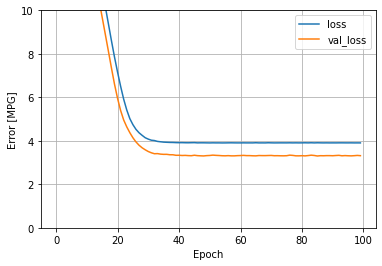

In [24]:
plot_loss(history)

In [25]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [29]:
x = tf.linspace(0.0, 250, 251) # can also use np.linspace
y = horsepower_model.predict(x)

In [30]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

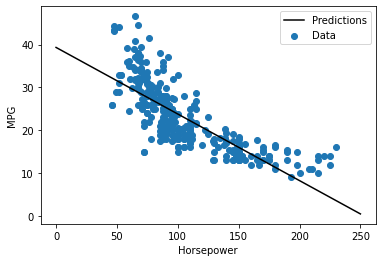

In [31]:
plot_horsepower(x, y)

In [32]:
# Multiple inputs now
# it's as easy as it gets, I don't even have to define shapes

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])


In [33]:
# checking everything works correctly
linear_model.predict(train_features[:10])

array([[ 0.99 ],
       [ 0.644],
       [ 0.431],
       [ 0.281],
       [-0.195],
       [ 0.357],
       [-1.097],
       [ 0.549],
       [-0.136],
       [ 1.349]], dtype=float32)

In [34]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.57 ],
       [-0.699],
       [-0.166],
       [ 0.15 ],
       [ 0.242],
       [ 0.064],
       [ 0.708],
       [ 0.544],
       [ 0.475]], dtype=float32)>

In [35]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [36]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2
)

Wall time: 5.41 s


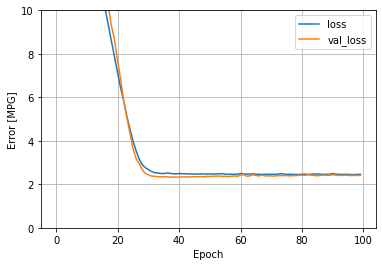

In [37]:
plot_loss(history)

In [38]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

In [39]:
# And finally a Deep Neural Network model

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [40]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Wall time: 5.42 s


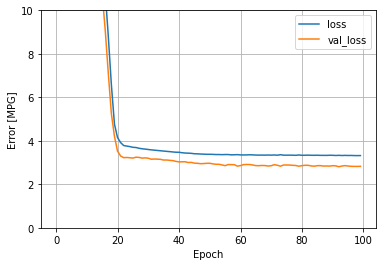

In [41]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

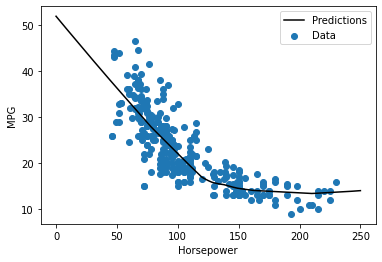

In [42]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [43]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0
)

In [44]:
# and the full model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [45]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

Wall time: 3.33 s


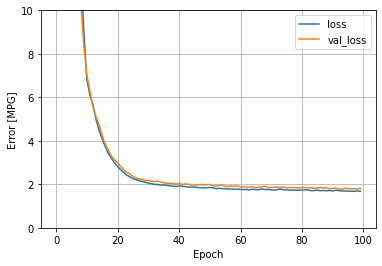

In [46]:
plot_loss(history)

In [47]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [48]:
# Performance check
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.943496
linear_model,2.534340
dnn_horsepower_model,3.450433
dnn_model,1.864599


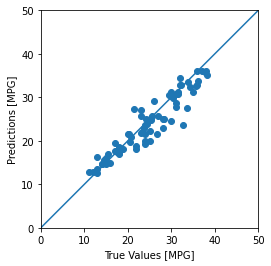

In [49]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

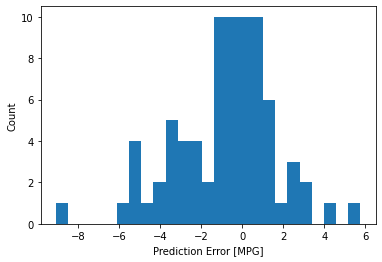

In [50]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [51]:
# saving the model
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [52]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0
)

In [53]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.943496
linear_model,2.534340
dnn_horsepower_model,3.450433
dnn_model,1.864599
reloaded,1.864599
